# COE Analysis

### Purpose

This is an explanatory analysis intended to enlighten new car buyers on how the COE bidding system in Singapore works, and what they ought to look out for when purchasing a new car.

### Audience

New car buyers who are not particularly affluent and are not familiar with the COE bidding system

### Context

Auditorium at EXPO conference

### Objectives:

1.  Find factors of COE pricing trends (premium & pqp)
2.  Find relationships/correlations among the factors

## A Brief Introduction to Singapore's COE Bidding System

In order to drive a vehicle on Singapore roads, one must obtain and possess a valid Certificate of Entitlement (COE) in addition to a valid driving licence. COE was implemented with the intent to reduce the number of cars on Singapore roads.

COEs are obtained through a process known as a bidding system. Car owners submit their bids, which is the amount they are willing to pay for their COE. There will be a quota, which is the number of COEs released during each bidding session (twice per month).

The quota is calculated based on 3 factors:

1.  Number of vehicles deregistered (expired or scrapped)
2.  Number of temporary COEs that were expired or cancelled
3.  Allowable vehicle population growth

<br />

Since 2012, [taxis are exempt from COE requirement](https://www.sgcarmart.com/news/article.php?AID=6475#:~:text=Taxis%20will%20be%20removed%20from,Authority%20(LTA)%20announced%20today.&text=Under%20the%20new%20move%2C%20taxi,under%20the%20Vehicle%20Quota%20System.)

[What about private hire cars and parallel imported](https://www.straitstimes.com/singapore/transport/private-hire-demand-pushes-up-car-coe-premiums)


For more detailed explanations, _[click here](https://ucars.sg/blog/complete-guide-coe-bidding/)_

## Import Dependencies

In [410]:
# data manipulation dependencies
import math
import numpy as np              # 
import pandas as pd             # Data Manipulation
import statsmodels.api as sm    # Linear Regression Model

# graphing dependencies
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go 
import plotly.express as px

## Preparation

### Set Seaborn Generic Theme

In [411]:
sns.set_theme(rc={'figure.figsize': (10, 6)}, palette='Set1')

### Load Dataset (from PDAS)

In [412]:
df = pd.read_csv('./data/clean.csv', index_col=0)
df['Quarter'] = df['Month'].map(lambda x: math.ceil(x / 3)) # move to pdas
print(df.dtypes, df.count(), df.describe().round(2), df.head(), sep='\n\n')

Date                      object
Bidding Session            int64
Category                  object
Quota                      int64
Successful Bids            int64
Received Bids              int64
Premium                    int64
PQP                        int64
Population                 int64
Number of Registered       int64
Number of Deregistered     int64
Year                       int64
Month                      int64
Quarter                    int64
dtype: object

Date                      400
Bidding Session           400
Category                  400
Quota                     400
Successful Bids           400
Received Bids             400
Premium                   400
PQP                       400
Population                400
Number of Registered      400
Number of Deregistered    400
Year                      400
Month                     400
Quarter                   400
dtype: int64

       Bidding Session    Quota  Successful Bids  Received Bids   Premium  \
count       

## Dataset Options

In [413]:
personal_cars_mask = df['Category'].str.contains(r'[AB]')
exclude_2018_mask = df['Year'] != 2018

df_personal_cars = df[personal_cars_mask]
df_exclude_2018 = df[exclude_2018_mask]

## Functions

In [414]:
def shorten(num: int, by: str = 'k') -> str:
    '''
    Shorten large numbers
    '''
    return str(round(num / 1000 if by == 'k' else num / 1000000)) + by

shortenVect = np.vectorize(shorten)

def convertDateTicks(i: int, monthOnly: bool = False, quarterOnly: bool = False, yearOnly: bool = False, base_Y: int = 2014, base_m: int = 1) -> str:
    '''
    Convert default tick values to dates (string format)
    '''
    month = int(i % 12) + base_m
    quarter = math.ceil(month / 3)
    year = int(i / 12 if month == 1 else (i - (i % 12)) / 12) + base_Y
    if monthOnly:
        return str(month)
    if quarterOnly:
        return str(quarter)
    if yearOnly:
        return str(year)
    return f'{month}/{year}'

convertDateTicksVect = np.vectorize(convertDateTicks)

def maskDate(i: int, how: str = 'Y') -> str:
    if how == 'Y':
        return convertDateTicks(i=i, yearOnly=True) if convertDateTicks(i=i, monthOnly=True) == '1' else ''
    if how == 'q':
        return convertDateTicks(i=i, quarterOnly=True) if (int(convertDateTicks(i=i, monthOnly=True)) - 1) % 4 == 0 else ''
    if how == 'm':
        return convertDateTicks(i=i, monthOnly=True)
    return ''

maskDateVect = np.vectorize(maskDate)

def verboseMonth(i: int, zeroIndex: bool = False, full: bool = False) -> str:
    return (['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] if not full else ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])[int(i if zeroIndex else i - 1)]

verboseMonthVect = np.vectorize(verboseMonth)

## Analysis

### Factor 1:   Vehicle Category

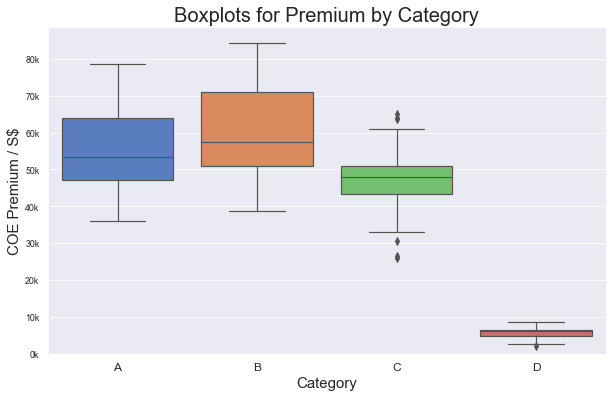

In [415]:
# COE by category
# COE is greatest for cars and cheapest for motorcycles (expected) (vehicle class)
with sns.axes_style(style='darkgrid'):
    with sns.plotting_context(context='paper'):
        with sns.color_palette(palette='muted'):
            ax1 = sns.boxplot(data=df, x='Category', y='Premium')
            ax1.set_title(label='Boxplots for Premium by Category', fontdict=dict(size=20))
            ax1.set_xlabel(xlabel='Category', fontdict=dict(size=15))
            ax1.set_xticklabels(labels=['A', 'B', 'C', 'D'], fontdict=dict(size=12))
            ax1.set_ylabel(ylabel='COE Premium / S$', fontdict=dict(size=15))
            ax1.set_ylim(bottom=0)
            ax1.set_yticklabels(labels=shortenVect(ax1.get_yticks()))
            plt.savefig('./assets/premium-category.png')

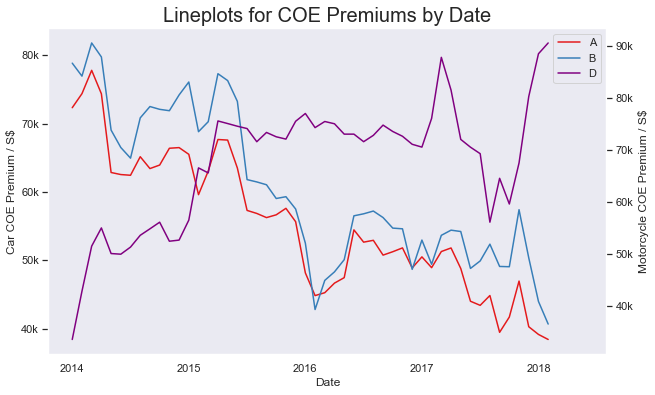

In [416]:
with sns.axes_style('darkgrid', {'axes.grid': False}):
    ax2 = sns.lineplot(data=df_personal_cars, x='Date', y='Premium', hue='Category', ci=None)
    ax2.set_ylabel(ylabel='Car COE Premium / S$')
    ax2.set_xlim(right=55)
    ax2_twin = ax2.twinx()
    ax2_twin.set_ylabel(ylabel='Motorcycle COE Premium / S$')
    sns.lineplot(data=df[df['Category'] == 'D'], x='Date', y='Premium', color='purple', ci=None, ax=ax2_twin)
    ax2.plot(np.nan, ls='-', color='purple', label = 'D')
    ax2.legend()
    ax2.set_title(label='Lineplots for COE Premiums by Date', fontsize=20)
    ax2.set_xticklabels(labels=maskDateVect(ax2.get_xticks()))
    ax2.set_yticklabels(labels=shortenVect(ax2.get_yticks()))
    ax2_twin.set_yticklabels(labels=shortenVect(ax2.get_yticks()))
    plt.savefig('./assets/premium-date.png')

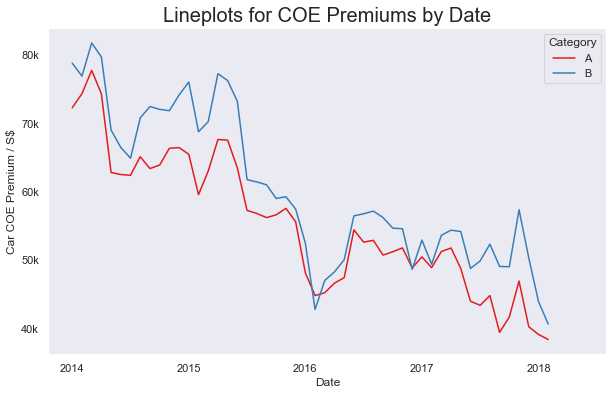

In [417]:
with sns.axes_style('darkgrid', {'axes.grid': False}):
    ax3 = sns.lineplot(data=df_personal_cars, x='Date', y='Premium', hue='Category', ci=None)
    ax3.set_ylabel(ylabel='Car COE Premium / S$')
    ax3.set_xlim(right=55)
    ax3.set_title(label='Lineplots for COE Premiums by Date', fontsize=20)
    ax3.set_xticklabels(labels=maskDateVect(ax3.get_xticks()))
    ax3.set_yticklabels(labels=shortenVect(ax3.get_yticks()))
    plt.savefig('./assets/lineplots-premium-by-date.png')

Category is the most defining factor when it comes to COE pricing, <br />
with Categories A and B topping the charts.

Since Category C is reserved for industrial purposes

Proceeding onwards, Categories C and D will be excluded from the analyses.

To provide better context, these are the definitions of the above categories:

+   A)  Internal Combustion Engine (ICE) cars with an engine capacity of at most 1600cc and Electric cars with engine power of at most 97kW
+   B)  Internal Combustion Engine (ICE) cars with an engine capacity of at least 1600cc and Electric cars with engine power of at least 97kW
+   C)  Goods Vehicles (like trucks, lorries) and Buses
+   D)  Motorcycles

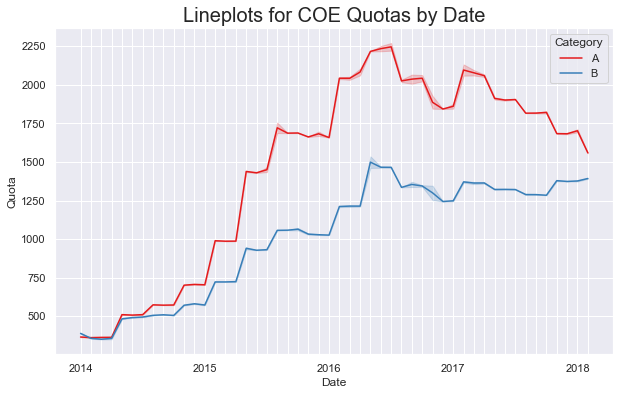

In [418]:
ax4 = sns.lineplot(data=df_personal_cars, x='Date', y='Quota', hue='Category')
ax4.set_ylabel(ylabel='Quota')
ax4.set_title(label='Lineplots for COE Quotas by Date', fontsize=20)
ax4.set_xticklabels(labels=maskDateVect(ax4.get_xticks()))
plt.savefig('./assets/lineplots-quota-by-date.png')

As you can see, category defines quota very much.

### Factor 2:   Quota of COE Bids

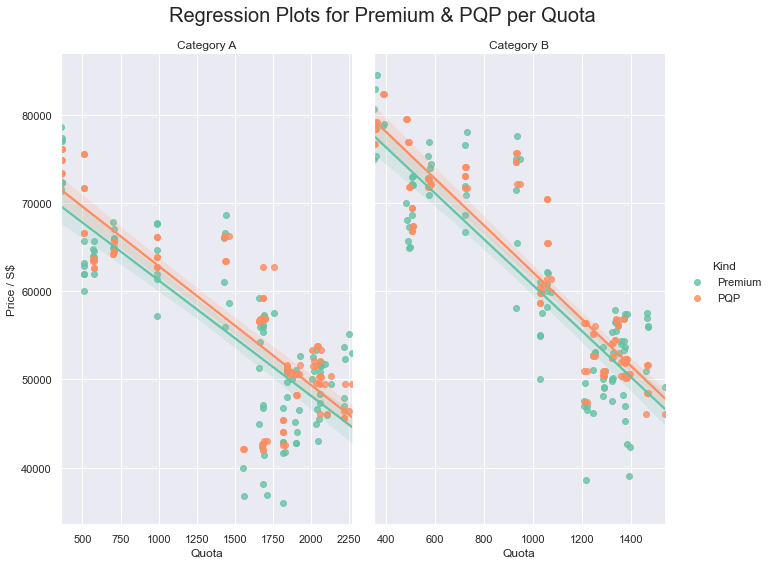

In [419]:
with sns.color_palette('Set2'):
    g1 = sns.FacetGrid(df_personal_cars.melt(id_vars=['Category', 'Quota'], value_vars=['Premium', 'PQP'], var_name='Kind', value_name='Price'), col='Category', hue='Kind', height=8, aspect=0.6, sharex=False)
    g1.map_dataframe(sns.regplot, data=tmp, x='Quota', y='Price')
    g1.set_xlabels('Quota')
    g1.set_ylabels('Price / S$')
    g1.set_titles(template='Category {col_name}')
    g1.add_legend()
    g1.fig.suptitle(t='Regression Plots for Premium & PQP per Quota', fontsize=20)
    g1.tight_layout()
    g1.savefig('./assets/premium-and-pqp-per-quota-by-category.png')

As quota increases, premiums and pqps drop. This makes sense as COE pricing is based on a bidding system. As the supply increases for a constant demand, prices usually increase.

### Factor 3:   Bidding Session

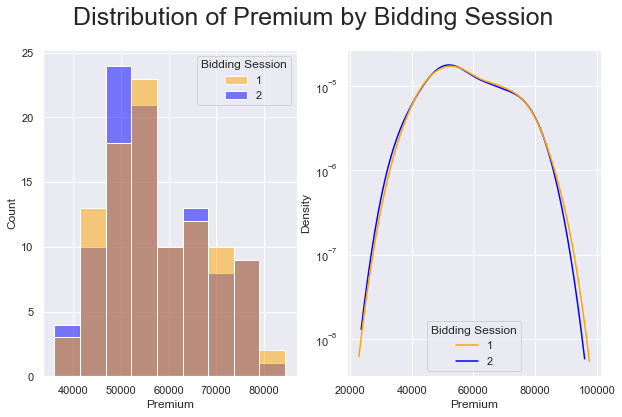

In [420]:
fig1, (ax5, ax6) = plt.subplots(nrows=1, ncols=2)
sns.histplot(data=df_personal_cars, x='Premium', hue='Bidding Session', fill=True, palette=['orange', 'blue'], ax=ax5)
sns.kdeplot(data=df_personal_cars, x='Premium', hue='Bidding Session', palette=['orange', 'blue'], ax=ax6)
ax6.set_yscale('log')
ax5.set_title(None)
ax6.set_title(None)
fig1.suptitle(t='Distribution of Premium by Bidding Session', fontsize=25)
fig1.savefig('./assets/distribution-premium-by-bidding-session.png')

There appears to be no significant difference in COE premium between bidding sessions from a broad overview. There seems to be much overlap between COE premium distributions of the 2 bidding sessions.

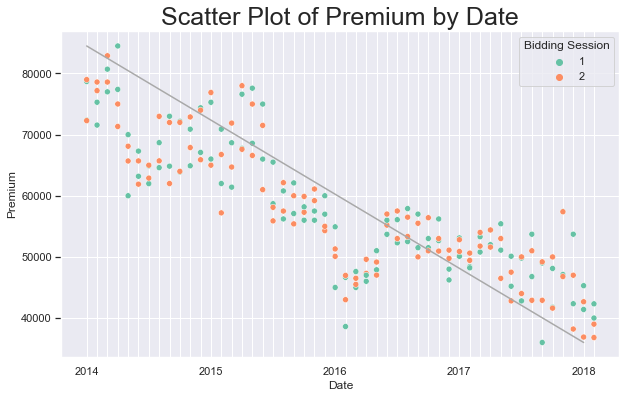

In [421]:
ax7 = sns.scatterplot(data=df_personal_cars, x='Date', y='Premium', hue='Bidding Session', palette='Set2')
c, m = sm.OLS.from_formula(formula='Premium ~ Year', data=df_personal_cars).fit().params
ax7_twin = ax7.twinx()
sns.lineplot(x=np.arange(5) * 12, y=(np.arange(5) + 2014) * m + c, color='darkgrey', ax=ax7_twin)
ax7_twin.set(yticks=[])
ax7.set_xticklabels(labels=maskDateVect(ax7.get_xticks()))
ax7.set_title('Scatter Plot of Premium by Date', fontsize=25)
plt.savefig('./assets/scatterplot-premium-by-date-by-session.png')

In addition, variations appear to be random and variances look roughly equal.

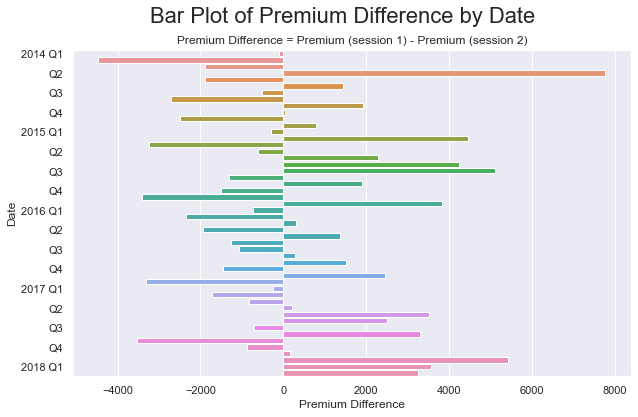

In [422]:
tmp1 = df_personal_cars.pivot_table(index='Date', columns='Bidding Session', values='Premium')
diff = (tmp1[1] - tmp1[2]).to_frame('Premium Difference').reset_index()
diff['Date'] = diff['Date'].apply(lambda x: pd.to_datetime(x, format='%Y-%m'))
diff.sort_values('Date', inplace=True)
ax8 = sns.barplot(data=diff, x='Premium Difference', y='Date')
ax8.set_yticks(ax8.get_yticks()[ax8.get_yticks() % 3 == 0])
plt.suptitle(t='Bar Plot of Premium Difference by Date', fontsize=22)
ax8.set_title('Premium Difference = Premium (session 1) - Premium (session 2)', fontsize=12)
ax8.set_yticklabels([(f'{convertDateTicks(i=i, yearOnly=True)} ' if i % 12 == 0 else '') + f'Q{convertDateTicks(i=i, quarterOnly=True)}' for i in ax8.get_yticks()])
plt.savefig('./assets/barplot-premium-diff-by-date.png')

However, when comparing bidding sessions by month, a new pattern emerges.

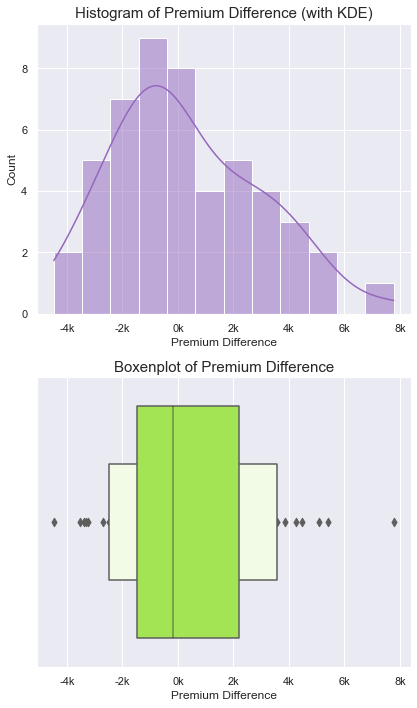

In [431]:
fig2, (ax9, ax10) = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))
sns.histplot(data=diff, x='Premium Difference', kde=True, bins=12, color='tab:purple', ax=ax9)
ax9.set_title('Histogram of Premium Difference (with KDE)', fontsize=15)
sns.boxenplot(data=diff, x='Premium Difference', palette='turbo', ax=ax10)
ax10.set_title('Boxenplot of Premium Difference', fontsize=15)
fig2.tight_layout()
ax9.set_xticklabels(labels=shortenVect(ax9.get_xticks()))
ax10.set_xticklabels(labels=shortenVect(ax10.get_xticks()))
fig2.savefig('./assets/distribution-premium-difference.png')

There is significant difference between the distribution

The differences can be summarised in the following table:

|   Session     |   Variability     |   Tendency    |
|---------------|-------------------|---------------|
|   1           |   Greater         |   Lower       |
|   2           |   Lower           |   Higher      |

More often than not, the resulting bid value of the 2<sup>nd</sup> bidding session is higher than that of the corresponding 1<sup>st</sup>.

Nonetheless, the 1<sup>st</sup> bidding session may occasionally produce a much higher COE bid price than its 2<sup>nd</sup> session counterpart.

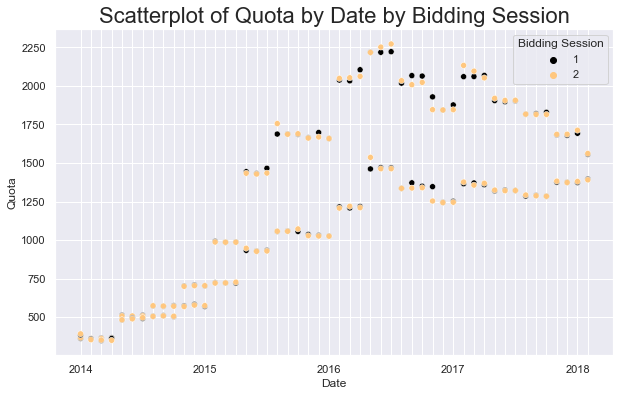

In [434]:
ax11 = sns.scatterplot(data=df_personal_cars, x='Date', y='Quota', hue='Bidding Session', palette='copper')
ax11.set_xticklabels(labels=maskDateVect(ax11.get_xticks()))
ax11.set_title(label='Scatterplot of Quota by Date by Bidding Session', fontsize=22)
plt.savefig('./assets/scatterplot-quota-by-date-and-session.png')

Bidding sessions do not really have a lot of differences in quota

### Correlation 1:  Quota ~ Year of Issuance

It appears that COE prices drop as time goes by.

However, time is not a factor in VQS, so there must be another reason why this is so. Correlation ≠ Causation.

It is more likely due to the increase trend in quotas in recent years.

### Correlation 2:  Quota ~ Year

Ah ha! The underlying reason why COE prices are on the decline is because the quota has been increasing with time.

### Correlation 3:  Quota ~ Car Population

Why has the quota been increasing recently?

### Correlation 2:  Quota ~ Deregistered

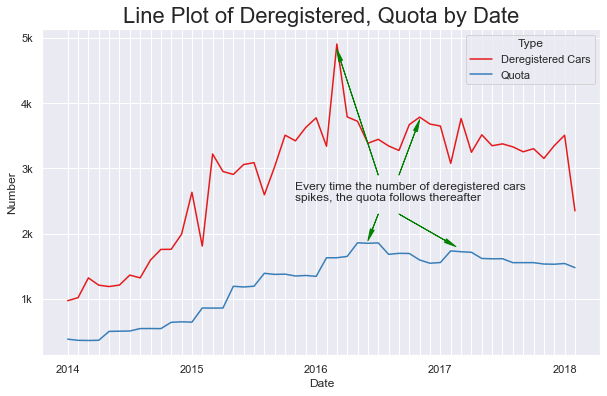

In [435]:
ax9 = sns.lineplot(data=df_personal_cars[['Date', 'Number of Deregistered', 'Quota']].melt(id_vars='Date', var_name='Type', value_name='Number'), x='Date', y='Number', hue='Type', ci=None)
ax9.set_xticklabels(labels=maskDateVect(ax9.get_xticks()))
ax9.annotate('Every time the number of deregistered cars\nspikes, the quota follows thereafter', xy=(22, 2500))
ax9.set_yticklabels(labels=shortenVect(ax9.get_yticks()))
ax9.set_ylabel(ylabel='Number')
ax9.annotate('', xy=(26, 4830), xytext=(30, 2900), arrowprops=dict(width=0.1, headwidth=4, color='green'), font=dict(size=12))
ax9.annotate('', xy=(37.5, 1800), xytext=(32, 2300), arrowprops=dict(width=0.1, headwidth=4, color='green'), font=dict(size=12))
ax9.annotate('', xy=(34, 3750), xytext=(32, 2900), arrowprops=dict(width=0.1, headwidth=4, color='green'), font=dict(size=12))
ax9.annotate('', xy=(29, 1890), xytext=(30, 2300), arrowprops=dict(width=0.1, headwidth=4, color='green'), font=dict(size=12))
ax9.legend(labels=('Deregistered Cars', 'Quota'), title='Type')
ax9.set_title(label='Line Plot of Deregistered, Quota by Date', fontsize=22)
plt.savefig('./assets/lineplots-deregistered-and-quota-by-date.png')

### Correlation 3:  Deregistered ~ Month

[ 0.  2.  4.  6.  8. 10. 12. 14.]
[Text(0.0, 0, '0'), Text(2.0, 0, '2'), Text(4.0, 0, '4'), Text(6.0, 0, '6'), Text(8.0, 0, '8'), Text(10.0, 0, '10'), Text(12.0, 0, '12'), Text(14.0, 0, '14')]


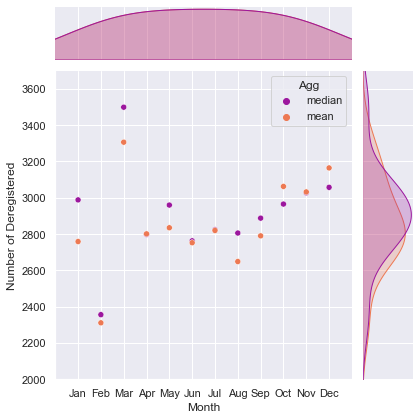

In [426]:
jg = sns.jointplot(data=df_personal_cars[exclude_2018_mask].groupby(by='Month')['Number of Deregistered'].agg(['median', 'mean']).reset_index().melt(id_vars='Month', var_name='Agg', value_name='Number of Deregistered'), x='Month', y='Number of Deregistered', hue='Agg', palette='plasma', xlim=(0, 13), ylim=(2000, 3700))
jg.ax_joint.set_xticks(np.arange(1, 13))
jg.ax_joint.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
jg.savefig('./assets/jointgrid-deregistered-by-month-and-agg.png')

<AxesSubplot:xlabel='Month', ylabel='Number of Deregistered'>

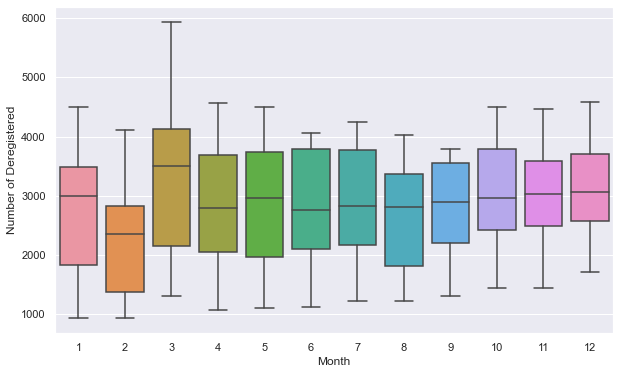

In [427]:
sns.boxplot(data=df_personal_cars[df_personal_cars['Year'] != 2018], x='Month', y='Number of Deregistered')

[ 0.  2.  4.  6.  8. 10. 12. 14.]
[Text(0.0, 0, '0'), Text(2.0, 0, '2'), Text(4.0, 0, '4'), Text(6.0, 0, '6'), Text(8.0, 0, '8'), Text(10.0, 0, '10'), Text(12.0, 0, '12'), Text(14.0, 0, '14')]


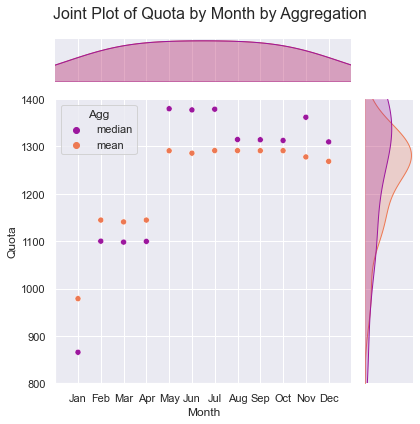

In [428]:
jg2 = sns.jointplot(data=df_personal_cars[exclude_2018_mask].groupby(by='Month')['Quota'].agg(['median', 'mean']).reset_index().melt(id_vars='Month', var_name='Agg', value_name='Quota'), x='Month', y='Quota', hue='Agg', palette='plasma', xlim=(0, 13), ylim=(800, 1400))
jg2.ax_joint.set_xticks(np.arange(1, 13))
jg2.ax_joint.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
jg2.fig.suptitle('Joint Plot of Quota by Month by Aggregation', fontsize=16)
jg2.fig.tight_layout()
jg2.savefig('./assets/jointgrid-quota-by-month-and-agg.png')

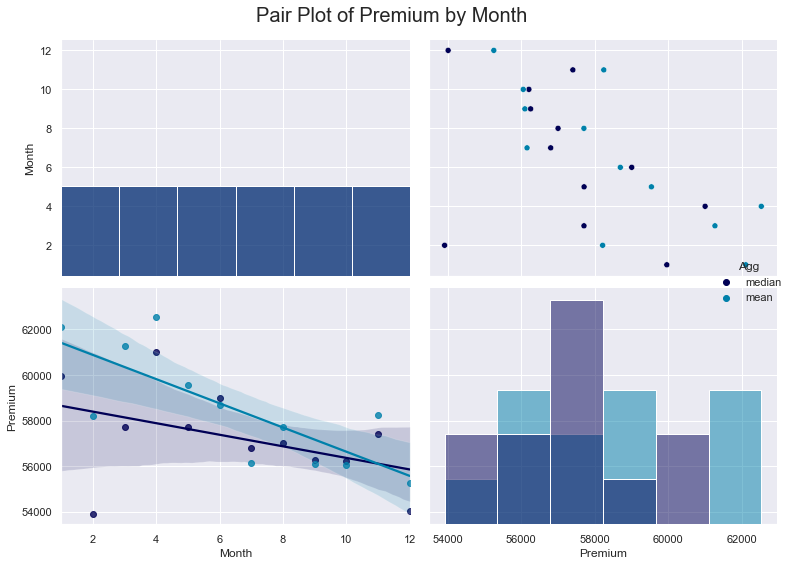

In [429]:
jg3 = sns.PairGrid(data=df_personal_cars[exclude_2018_mask].groupby(by='Month')['Premium'].agg(['median', 'mean']).reset_index().melt(id_vars='Month', var_name='Agg', value_name='Premium'), hue='Agg', palette='ocean')
jg3.fig.set_size_inches((10, 8))
jg3.map_diag(sns.histplot)
jg3.map_lower(sns.regplot)
jg3.map_upper(sns.scatterplot)
jg3.add_legend()
jg3.fig.suptitle(t='Pair Plot of Premium by Month', fontsize=20)
jg3.fig.tight_layout()
jg3.savefig('./assets/pairplot-premium-by-month.png')
jg3

Why spike dereg at start of month? Buy in april is best. dont buy in march.

### Somehow, quota not always increase but premium is

In [438]:
px.scatter(data_frame=df_personal_cars, x='Quota', y='Premium', color='Category', size='Successful Bids', animation_frame='Date', range_x=(200, 3000), range_y=(0, 100000))
# df.reset_index().assign(date=lambda x: x['month'].to_string() + '/' + x['year'].to_string()).head()

### quota, bids success and bids received all positively correlated

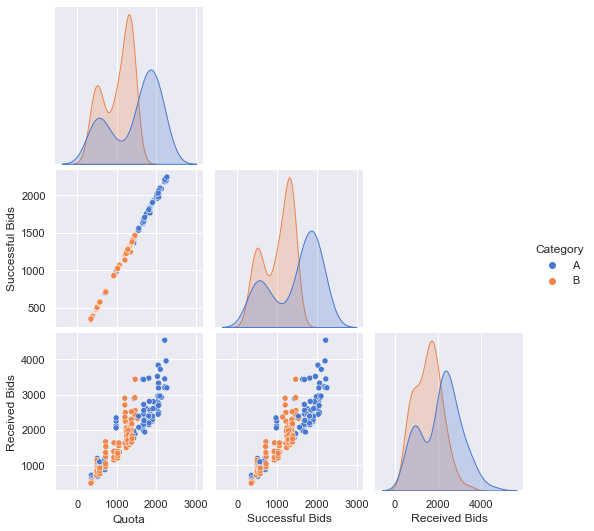

In [290]:
sns.pairplot(data=df_personal_cars[['Quota', 'Successful Bids', 'Received Bids', 'Category']], diag_kind='kde', hue='Category', palette='muted', corner=True)

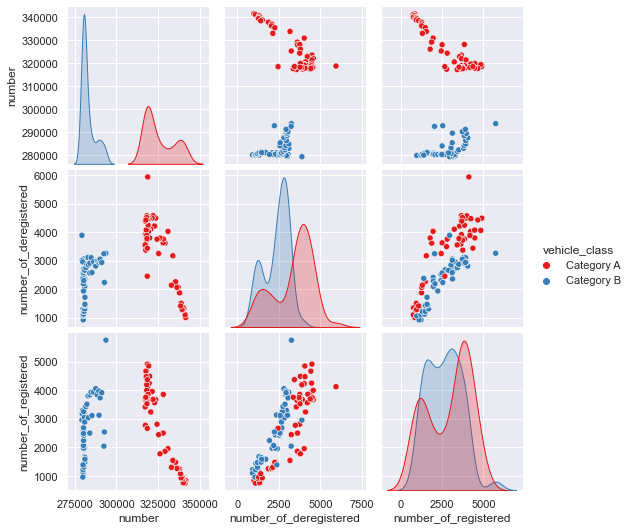

In [21]:
sns.pairplot(data=df_personal_cars[['number', 'number_of_deregistered', 'number_of_registered', 'vehicle_class']], hue='vehicle_class')

('A', 'PQP')
('B', 'PQP')
('A', 'Premium')
('B', 'Premium')


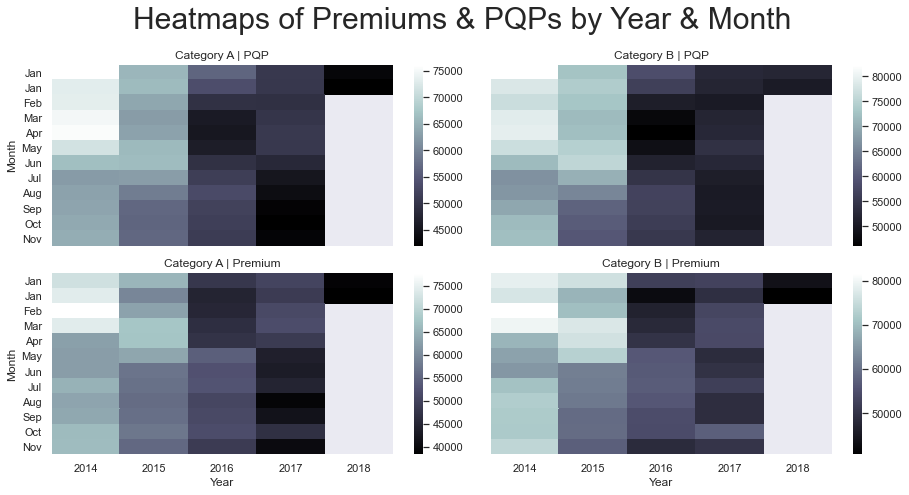

In [352]:
fig4, ((ax91, ax92), (ax93, ax94)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 7))
axes3 = (ax91, ax92, ax93, ax94)
cats = ('A', 'B')
types = ('Premium', 'PQP')
for i, f in enumerate(axes3):
    c = cats[int(i % 2 != 0)]
    t = types[int(i < 2)]
    print((c, t))
    sns.heatmap(data=df[df['Category'] == c].pivot_table(index='Month', columns='Year', values=t), cmap=sns.color_palette(palette='bone', as_cmap=True), ax=f)
    f.set_title(f'Category {c} | {t}')
    if i < 2:
        f.set_xticklabels(labels=[])
        f.set_xlabel(xlabel='')
    if i % 2 != 0:
        f.set_yticklabels(labels=[])
        f.set_ylabel(ylabel='')
    else:
        f.set_yticklabels(labels=verboseMonthVect(f.get_yticks()), rotation=0)
    # f.set_yticklabels(labels=[])
# fig4.
# ax99.annotate()
fig4.suptitle(t='Heatmaps of Premiums & PQPs by Year & Month', fontsize=30)
fig4.tight_layout()
fig4.savefig('./assets/heatmaps-premium-and-pqp-by-year-and-month.png')
# df_personal_cars.pivot_table(index='Month', columns='vehicle_class', values='premium').sort_values('Category B')
# df_personal_cars.groupby(by=['month']).median()

# TRASH

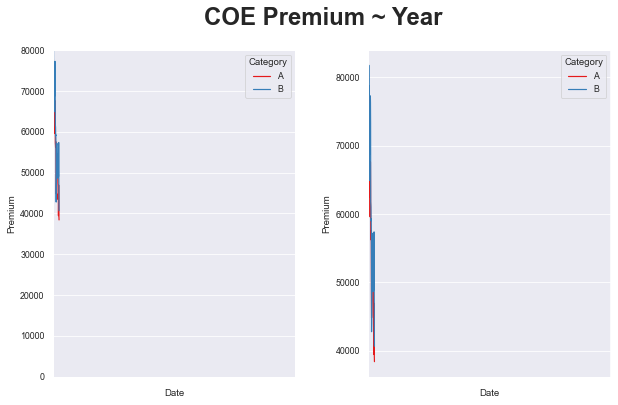

In [354]:
with sns.axes_style(style='darkgrid'):
    with sns.plotting_context(context='paper'):
        # fig2 = plt.Figure(figsize=(10, 4))
        fig2, (ax2, ax3) = plt.subplots(nrows=1, ncols=2)
        fig2.suptitle('COE Premium ~ Year', fontproperties={'size': 24, 'weight': 'bold'})
        plt.subplots_adjust(wspace=0.3)
        # ax2 = plt.subplot2grid(shape=(1, 2), loc=(0, 0))
        sns.lineplot(data=df_personal_cars.groupby(by=['Date', 'Year', 'Category']).median(), x='Date', y='Premium', hue='Category', ax=ax2)
        # ax3 = plt.subplot2grid(shape=(1, 2), loc=(0, 1))
        sns.lineplot(data=df_personal_cars.groupby(by=['Date', 'Year', 'Category']).median(), x='Date', y='Premium', hue='Category', ax=ax3)
        axes2 = [ax2, ax3]
        for a in axes2:
            a.set_xticks([i for i in range(2014, 2019)])
        ax2.set_ylim(bottom=0, top=80000)
        ax2

In [ ]:
sns.heatmap(data=df_personal_cars.pivot_table())

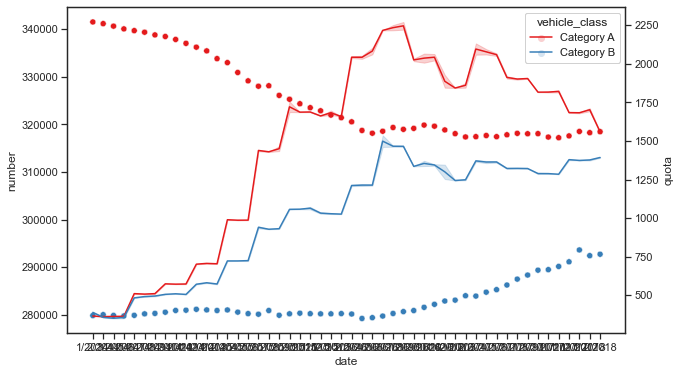

In [65]:
# number and pop
with sns.axes_style(style='ticks'):
    ax13 = sns.scatterplot(data=df_personal_cars, x='date', y='number', hue='vehicle_class')
    ax14 = ax13.twinx()
    sns.lineplot(data=df_personal_cars, x='date', y='quota', hue='vehicle_class', ax=ax14)
    # sns.relplot(data=tmp2, x='year', y='number_of_deregistered', kind='line', estimator=np.sum, ax=ax4)

In [23]:
### Bids Success ~

index  bidding_no  quota  bids_success  bids_received  premium  \
year month                                                                   
2014 1        0.5         1.5  366.0         362.5          673.5  72329.5   
     2        8.5         1.5  362.0         357.0          709.5  74382.5   
     3       16.5         1.5  363.5         358.0          596.0  77800.5   
     4       24.5         1.5  364.0         358.5          525.0  74367.5   
     5       32.5         1.5  511.0         509.0          836.5  62845.5   

                pqp  number_of_deregistered  number_of_registered    number  
year month                                                                   
2014 1      76109.0                  1011.0                 844.0  341519.0  
     2      73237.0                  1104.0                 754.0  341169.0  
     3      73431.0                  1330.0                 806.0  340645.0  
     4      74838.0                  1347.0                 768.0  340066.0  
     5      75517.0                  1271.0                 905.0  339700.0

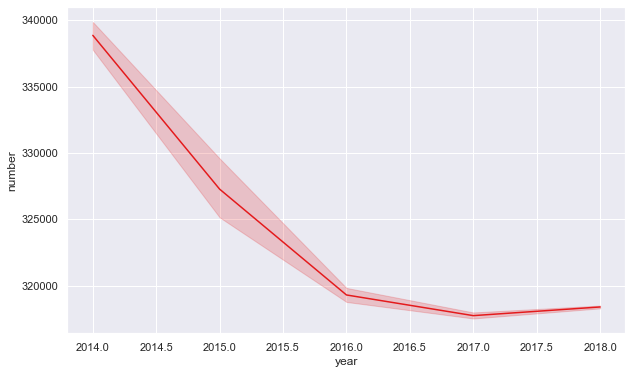

In [24]:
c = df[df['vehicle_class'].str.contains('Category A')].groupby(['year', 'month']).mean()
sns.lineplot(data=c, x='year', y='number')
c.head()

In [25]:
# Quota by year
# sns.lineplot(data=df.groupby('year').sum(), x='year', y='quota')
# df.groupby('year').sum().head()
px.scatter(data_frame=df[['date', 'quota', 'bids_received', 'bids_success']].melt(id_vars='date', var_name='kind', value_name='freq'), x='date', y='freq', color='kind')

<AxesSubplot:xlabel='vehicle_class', ylabel='year'>

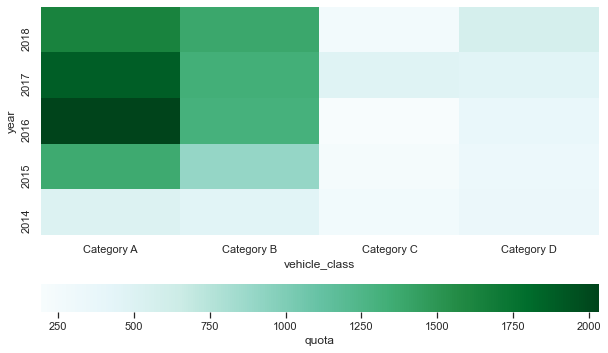

In [26]:
sns.heatmap(df.pivot_table(index='year', columns='vehicle_class', values='quota').sort_index(ascending=False), cmap='BuGn', cbar_kws={'orientation': 'horizontal', 'label': 'quota'})

In [27]:
go.Figure(go.Heatmap(z = df.pivot_table(index='year', columns='vehicle_class', values='quota').sort_index(ascending=False), colorscale='Greens', reversescale=True))

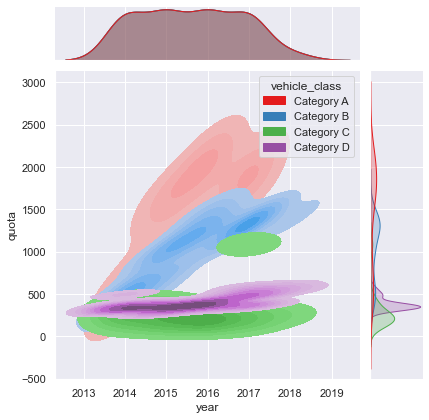

In [28]:
sns.jointplot(data=df, x='year', y='quota', hue='vehicle_class', kind='kde', fill=True)

In [29]:
px.bar(data_frame=df, x='year', y='bids_success', color='vehicle_class')

In [30]:
df.head()

index  month  bidding_no vehicle_class  quota  bids_success  bids_received  \
0      0      1           1    Category A    364           361            623   
1      1      1           2    Category A    368           364            724   
2      2      1           1    Category B    386           377            581   
3      3      1           2    Category B    393           388            512   
4      4      1           1    Category C    258           252            337   

   premium    pqp  number_of_deregistered  number_of_registered  number  year  \
0    72369  76109                    1011                   844  341519  2014   
1    72290  76109                    1011                   844  341519  2014   
2    78700  82333                     927                  1224  279902  2014   
3    79000  82333                     927                  1224  279902  2014   
4    48889  58989                     711                   309  154144  2014   

     date  
0  1/2014  
1  1/2014  
2  1/2014  
3  1/2014  
4  1/2014

In [31]:
px.scatter_matrix(data_frame=df[['quota', 'bids_received', 'bids_success']])

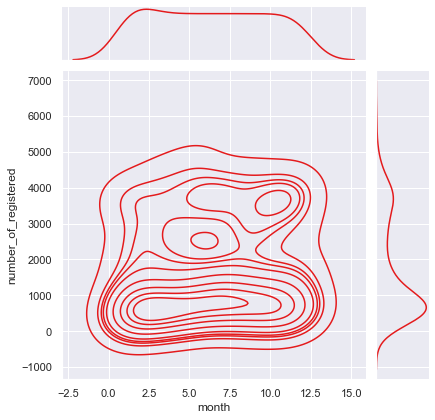

In [32]:
sns.jointplot(data=df, x='month', y='number_of_registered', kind='kde')

In [33]:
px.scatter(data_frame=df, x='month', y='premium', color='vehicle_class', size='quota', animation_frame='year', animation_group='vehicle_class')